# Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
import pdb

from tensorflow.keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Dense, Input


Bad key "backend.qt4" on line 29 in
/Users/thsyu/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  after removing the cwd from sys.path.
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  after removing the cwd from sys.path.
Using TensorFlow backend.


# Predicting the mean, standard deviation of 1D Gaussian

## Using Neural Nets

In [2]:
def predict(model):
    #pdb.set_trace()
    # Make 1000 new Gaussians to apply the model to
    predX, predy = make_gaussians(1000)
    
    # Apply the model to get predicted means and sigmas of the Gaussians
    pmeans, psigs = model.predict(predX, batch_size=None, verbose=0)
    
    # Check distribution of difference between true and predicted means, sigmas
    plt.subplot(211)
    _, _, _ = plt.hist(predy[:, 0] - pmeans.flatten(), bins=30)
    plt.subplot(212)
    _, _, _ = plt.hist(predy[:, 1] - psigs.flatten(), bins=30)
    
    plt.show()
    
    # Check the relation between true and predicted means, sigmas
    oto_means = np.linspace(-1., 1., 32) # one-to-one relation for means
    oto_sigmas = np.linspace(0.25, 4.0, 32) # one-to-one relation for sigmas
    
    plt.subplot(211)
    # Plot the true y's and predicted y's from the NN model
    plt.plot(predy[:, 0], pmeans.flatten(), marker='.')
    # Plot the 1-to-1 line
    plt.plot(oto_means, oto_means, color='black', ls='--')
    plt.xlim(-1.0, 1.0)
    plt.ylim(-1.0, 1.0)
    plt.xlabel('True value')
    plt.ylabel('Predicted value')
    plt.title(r'$\mu$')
    
    plt.subplot(212)
    plt.plot(predy[:, 1], psigs.flatten(), marker='.')
    plt.plot(oto_sigmas, oto_sigmas, color='black', ls='--')
    plt.xlim(0.25, 4.0)
    plt.ylim(0.25, 4.0)
    plt.xlabel('True value')
    plt.ylabel('Predicted value')
    plt.title(r'$\sigma$')
    
    #plt.savefig('gaussian_characteristics.pdf')
    plt.show()

### Generate Gaussian given mu, sigma

In [3]:
# Calculate a Gaussian given its mean and standard deviation
def gaussian(x_vals, mu, sigma):
    return np.exp(-0.5 * ((x_vals - mu)/sigma)**2) / (sigma * np.sqrt(2*np.pi))

# Make array that describes Gaussian
def make_gaussians(num, mu_min=-1.0, mu_max=1.0, sig_min=0.25, sig_max=4.0): 

    means = np.random.uniform(mu_min, mu_max, num)
    sigmas = np.random.uniform(sig_min, sig_max, num)

    x_vals = np.linspace(-10.0, 10.0, 32)
    models = np.zeros((num, 32))

    for i in range(num):
        models[i] = gaussian(x_vals, means[i], sigmas[i])
    
    # Also want to save and return the true means, sigmas used for the Gaussians
    targets = np.vstack((means, sigmas)).T

    return models, targets

In [4]:
# Create training and test sets
def generate_dataset(n_train=10000, n_test=1000):
    X_train, y_train = make_gaussians(n_train)
    X_test, y_test = make_gaussians(n_test)
    
    return X_train, y_train, X_test, y_test

### Create, compile, fit, and evaluate NN model

In [5]:
# Check out: https://datascience.stackexchange.com/questions/28003/get-multiple-output-from-keras
# for multi-output regression using Keras NNs

def evaluate_model(X_train, y_train, X_test, y_test):
    # Create model
    
    # Here, this means that our training set of 10000 samples will be divided into
    # 10000/batch_size = 10000/10 = 1000 batches, each with 10 samples. The model
    # weights will be updated after each batch of 10.
    # One epoch will involve 1000 batches, or 1000 updates to the model
    # Since we are running 100 epochs, it will go through 100*1000 batches = 100,000 batches
    # during the entire process
    verbose, epochs, batch_size = 1, 10, 16
    input_shape = X_train.shape[1]

    inputs = Input(shape=(input_shape,))

    x = Dense(10, activation='relu')(inputs)
    x = Dense(5, activation='relu')(x)
    out1 = Dense(1, activation='linear', name='mean')(x)
    out2 = Dense(1, activation='linear', name='sigma')(x)

    # Create model with input layer and dense layers
    model = Model(inputs=inputs, outputs=[out1, out2])
    model.compile(loss='mse', optimizer='rmsprop')#, metrics=['accuracy'])

    # Fit model
    model.fit(X_train, [y_train[:,0], y_train[:,1]], epochs=epochs, verbose=verbose)
    
    pdb.set_trace()
    model.save('test_gauss1d')

    # Run model on test set
    accuracy = model.evaluate(X_test, [y_test[:,0], y_test[:,1]], batch_size=batch_size, verbose=0)
    
    #print (model.metrics_names)
    predict(model)
    
    return accuracy

In [6]:
# If relevant, check accuracy of the model
def summarize_results(scores):
    #print(scores)
    m, s = np.mean(scores), np.std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
    
    return

In [7]:
def detect_features(repeats=3):
    # Generate data
    X_train, y_train, X_test, y_test = generate_dataset()
    
    # Repeat experiment
    scores = list()
    
    for r in range(repeats):
        score = evaluate_model(X_train, y_train, X_test, y_test)
        #pdb.set_trace()
        # **** score[0] below is currently the loss
        score = np.asarray(score[0]) #* 100.0
        print('>#%d: %.3f' % (r + 1, score))
        scores.append(score)
        
    # Summarize results
    #summarize_results(scores)
    
    return

Epoch 1/10
10000/10000 [==============================] - 1s 60us/step - loss: 2.9696 - mean_loss: 0.2810 - sigma_loss: 2.6855
Epoch 2/10
10000/10000 [==============================] - 0s 45us/step - loss: 0.3019 - mean_loss: 0.1435 - sigma_loss: 0.1580
Epoch 3/10
10000/10000 [==============================] - 0s 44us/step - loss: 0.0480 - mean_loss: 0.0336 - sigma_loss: 0.0144
Epoch 4/10
10000/10000 [==============================] - 0s 44us/step - loss: 0.0126 - mean_loss: 0.0084 - sigma_loss: 0.0041
Epoch 5/10
10000/10000 [==============================] - 0s 46us/step - loss: 0.0050 - mean_loss: 0.0027 - sigma_loss: 0.0023
Epoch 6/10
10000/10000 [==============================] - 0s 46us/step - loss: 0.0031 - mean_loss: 0.0013 - sigma_loss: 0.0019
Epoch 7/10
10000/10000 [==============================] - 0s 46us/step - loss: 0.0025 - mean_loss: 7.7845e-04 - sigma_loss: 0.0017
Epoch 8/10
10000/10000 [==============================] - 0s 45us/step - loss: 0.0022 - mean_loss: 5.6556e-

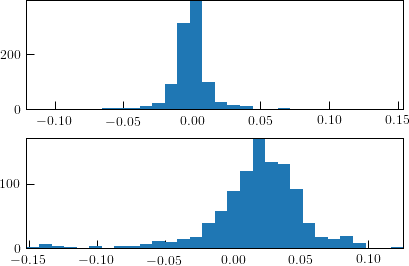

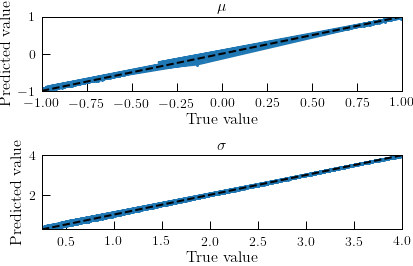

>#1: 0.002
Epoch 1/10
10000/10000 [==============================] - 1s 58us/step - loss: 2.0277 - mean_loss: 0.5625 - sigma_loss: 1.4629
Epoch 2/10
10000/10000 [==============================] - 0s 43us/step - loss: 0.2819 - mean_loss: 0.2391 - sigma_loss: 0.0425
Epoch 3/10
10000/10000 [==============================] - 0s 43us/step - loss: 0.0793 - mean_loss: 0.0645 - sigma_loss: 0.0147
Epoch 4/10
10000/10000 [==============================] - 0s 44us/step - loss: 0.0239 - mean_loss: 0.0132 - sigma_loss: 0.0107
Epoch 5/10
10000/10000 [==============================] - 0s 43us/step - loss: 0.0108 - mean_loss: 0.0034 - sigma_loss: 0.0074
Epoch 6/10
10000/10000 [==============================] - 0s 48us/step - loss: 0.0078 - mean_loss: 0.0025 - sigma_loss: 0.0053
Epoch 7/10
10000/10000 [==============================] - 1s 51us/step - loss: 0.0060 - mean_loss: 0.0022 - sigma_loss: 0.0039
Epoch 8/10
10000/10000 [==============================] - 1s 52us/step - loss: 0.0047 - mean_loss: 0

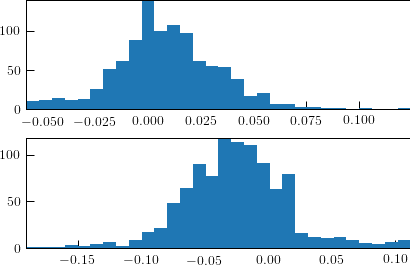

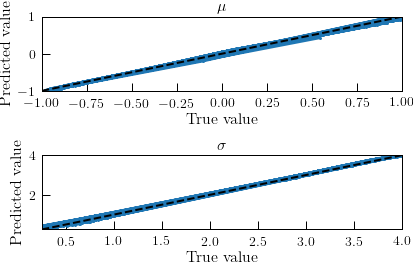

>#2: 0.003
Epoch 1/10
10000/10000 [==============================] - 1s 63us/step - loss: 2.8706 - mean_loss: 0.3500 - sigma_loss: 2.5170
Epoch 2/10
10000/10000 [==============================] - 0s 45us/step - loss: 0.2708 - mean_loss: 0.1563 - sigma_loss: 0.1143
Epoch 3/10
10000/10000 [==============================] - 0s 47us/step - loss: 0.0527 - mean_loss: 0.0380 - sigma_loss: 0.0147
Epoch 4/10
10000/10000 [==============================] - 1s 51us/step - loss: 0.0130 - mean_loss: 0.0062 - sigma_loss: 0.0068
Epoch 5/10
10000/10000 [==============================] - 0s 48us/step - loss: 0.0055 - mean_loss: 0.0023 - sigma_loss: 0.0032
Epoch 6/10
10000/10000 [==============================] - 1s 50us/step - loss: 0.0032 - mean_loss: 0.0014 - sigma_loss: 0.0018
Epoch 7/10
10000/10000 [==============================] - 0s 45us/step - loss: 0.0024 - mean_loss: 0.0011 - sigma_loss: 0.0014
Epoch 8/10
10000/10000 [==============================] - 0s 47us/step - loss: 0.0021 - mean_loss: 9

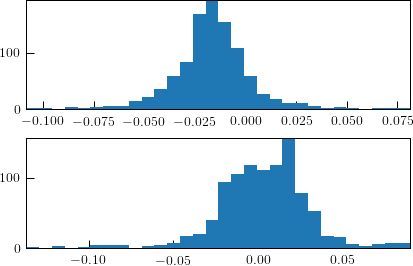

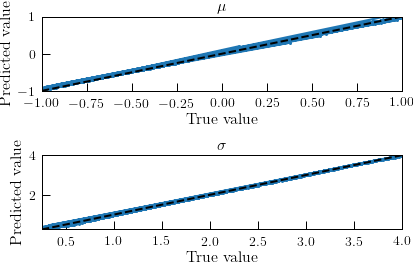

>#3: 0.001


In [8]:
detect_features()

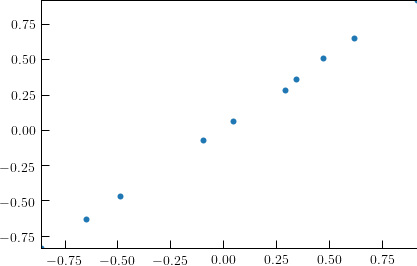

In [21]:
tst = load_model('test_gauss1d')
a, b, c, d = generate_dataset(10, 10)
e = tst.predict(c)

plt.plot(d[:,0], e[0], 'o')
plt.show()

## Using Support Vector Machines (SVM) for classification

### Support Vector Regression

The method of Support Vector Classification can be extended to solve regression problems. This method is called Support Vector Regression.

There are three different implementations of Support Vector Regression: SVR, NuSVR and LinearSVR. LinearSVR provides a faster implementation than SVR but only considers the linear kernel, while NuSVR implements a slightly different formulation than SVR and LinearSVR. See Implementation details for further details.

See Section 1.4.2 of https://scikit-learn.org/stable/modules/svm.html

### Create, compile, and fit model, and use it to predict

In [ ]:
# Modelled this following the 'Separate Model for Each Output (MultiOutputRegressor)'
# section of https://machinelearningmastery.com/multi-output-regression-models-with-python/
# but changed LinearSVR to SVR
from sklearn.datasets import make_regression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR

# create datasets
trainX, trainy, testX, testy = generate_dataset()

# define model
model = SVR(kernel='rbf')
wrapper = MultiOutputRegressor(model)

# fit model
wrapper.fit(trainX, trainy)

# make a prediction
yhat = wrapper.predict(testX)

# summarize prediction
#print(yhat)

#### Plot predictions vs true

In [ ]:
x_vals = np.linspace(-10.0, 10.0, 32)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.hist(yhat[:, 0] - testy[:, 0], bins=30)
ax1.set_xlabel('(predicted - true) value')
ax1.set_title(r'$\mu$')

ax2.hist(yhat[:, 1] - testy[:, 1], bins=30)
ax2.set_xlabel('(predicted - true) value')
ax2.set_title(r'$\sigma$')

fig.show()

In [ ]:
num_lines= yhat.shape[0]
cm_subsection = np.linspace(0.0, 1.0, 10) 

colors = [ cm.jet(x) for x in cm_subsection ]

# Plot the true Gaussians (solid lines) and predicted Gaussians (dashed lines) for a sample of 10
for i in range(0, 10):#testy.shape[0]):
    plt.plot(x_vals, gaussian(x_vals, yhat[i][0], yhat[i][1]), color=colors[i])
    plt.plot(x_vals, gaussian(x_vals, testy[i][0], testy[i][1]), color=colors[i], ls='--')
    
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(yhat[:,0], testy[:,0], marker='o')
ax1.plot(np.linspace(-1.0, 1.0), np.linspace(-1.0, 1.0), color='black', ls='--')
ax1.set_xlabel('Predicted value')
ax1.set_ylabel('True value')
ax1.set_title(r'Gaussian $\mu$')

ax2.plot(yhat[:,1], testy[:,1], marker='o')
ax2.plot(np.linspace(0.25, 4.0), np.linspace(0.25, 4.0), color='black', ls='--')
ax2.set_xlabel('Predicted value')
ax2.set_ylabel('True value')
ax2.set_title(r'Gaussian $\sigma$')

fig.show()